In [1]:
import torch
import gc
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

import dataloader as defencer

In [5]:
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


In [2]:
# Free cuda memory
# Reference: https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/13
def freemem():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and torch.is_tensor(obj.data):
            del obj
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

Image train=67581, Fence train=18
Image val=8448, Fence val=9
Image test=8448, Fence test=3


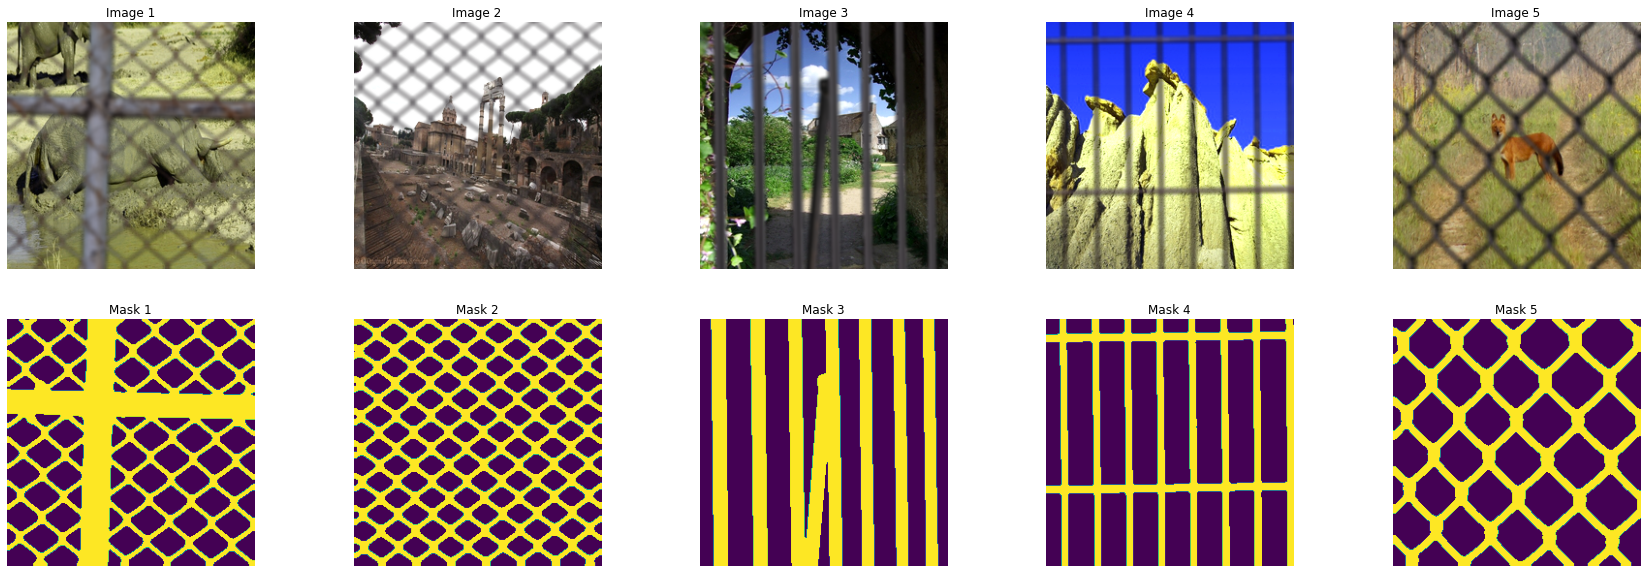

In [3]:
loader_train, loader_val, loader_test = defencer.Get_DataLoaders(8, 10)

In [4]:
resnet50 = models.resnet50(pretrained=True)
x, y = next(iter(loader_val))
resnet50.fc = nn.Linear(2048, 65536)

summary(resnet50, (3, 256, 256))
for param in resnet50.parameters():
    param.require_grad = False
resnet50.fc.requires_grad_(True)

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [7]:
freemem()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet50 = resnet50.to(device)

Device: cpu
